# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察填補缺值以及 標準化 / 最小最大化 對數值的影響

# [作業重點]
- 觀察替換不同補缺方式, 對於特徵的影響 (In[4]~In[6], Out[4]~Out[6])
- 觀察替換不同特徵縮放方式, 對於特徵的影響 (In[7]~In[8], Out[7]~Out[8])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = 'C:/Users/user/Desktop/ML marathon/data/Feature Engineering/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test]) # 因為要調整缺失值，先把全部資料都拼在一起
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



In [3]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
train_num = train_Y.shape[0] # 紀錄訓練資料集有多少數據，待會就從 df 取這麼多個。
df.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


# 作業1
* 試著在補空值區塊, 替換並執行兩種以上填補的缺值, 看看何者比較好?

#### 先看一下各個欄位資料類型

In [60]:
print(df.isnull().sum()) # '年齡' 跟 '票價' 有缺值

Pclass      0
Age       263
SibSp       0
Parch       0
Fare        1
dtype: int64


In [26]:
df.median()

Pclass     3.0000
Age       28.0000
SibSp      0.0000
Parch      0.0000
Fare      14.4542
dtype: float64

In [27]:
df.mean()

Pclass     2.294882
Age       29.881138
SibSp      0.498854
Parch      0.385027
Fare      33.295479
dtype: float64

mean of Age:  29.881137667304014
median of Age:  28.0
mode of Age: 24.0
skewness of Age:  0.39153679952469117


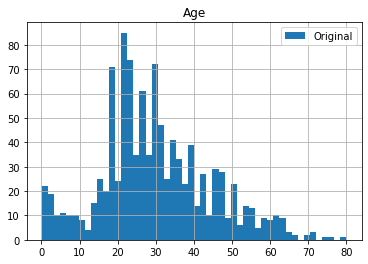

In [77]:
import matplotlib.pyplot as plt
# 畫出年齡的直方圖
print('mean of Age: ', df['Age'].mean())
print('median of Age: ', df['Age'].median())
print('mode of Age:', df['Age'].value_counts().index[0])
print('skewness of Age: ', 3 * (df['Age'].mean() - df['Age'].median()) / df['Age'].std()) # 的確有偏態
df['Age'].hist(bins = 50)
plt.title('Age')
plt.legend(['Original'])
plt.show()

mean of Fare:  33.2954792813456
median of Fare:  14.4542
mode of Fare: 8.05
skewness of Fare:  1.0920651509587351


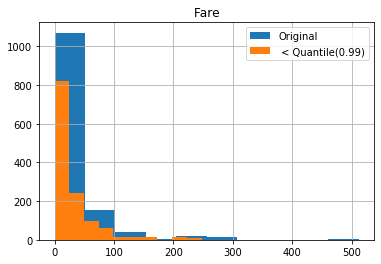

In [78]:
# 畫出票價的直方圖
print('mean of Fare: ', df['Fare'].mean())
print('median of Fare: ', df['Fare'].median())
print('mode of Fare:', df['Fare'].value_counts().index[0])
print('skewness of Fare: ', 3 * (df['Fare'].mean() - df['Fare'].median()) / df['Fare'].std()) # 的確有偏態
df['Fare'].hist()
df[df['Fare'] < df['Fare'].quantile(0.99)]['Fare'].hist()
plt.title('Fare')
plt.legend(['Original', ' < Quantile(0.99)'])
plt.show()

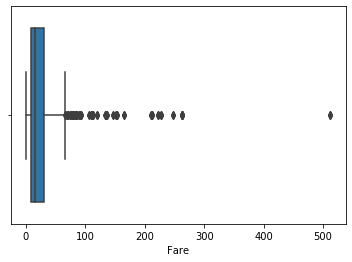

In [82]:
import seaborn as sns
sns.boxplot(df['Fare']) # 看來有不少人坐頭等艙
plt.show()

#### 某些欄位數值有偏態，或者並非連續。如果要更確實的填補缺值可能要分開進行。

In [33]:
# 空值補 -1, 做羅吉斯迴歸
df_m1 = df.fillna(-1)
train_X = df_m1[:train_num]
estimator = LogisticRegression()
score_m1 = cross_val_score(estimator, train_X, train_Y, cv=5).mean()
print('cross valadation score (NA fill with -1): {:.06f}'.format(score_m1))

# 空值補 0, 做羅吉斯迴歸
df_0 = df.fillna(0)
train_X = df_0[:train_num]
score_0 = cross_val_score(estimator, train_X, train_Y, cv = 5).mean()
print('cross valadation score (NA fill with 0): {:.06f}'.format(score_0))

# 空值補平均值, 做羅吉斯迴歸
df_mn = df.fillna(df.mean())
train_X = df_mn[:train_num]
score_mn = cross_val_score(estimator, train_X, train_Y, cv = 5).mean()
print('cross valadation score (NA fill with mean): {:.06f}'.format(score_mn))

# 空值補中位數, 做羅吉斯迴歸
df_md = df.fillna(df.median())
train_X = df_md[:train_num]
score_md = cross_val_score(estimator, train_X, train_Y, cv = 5).mean()
print('cross valadation score (NA fill with median): {:.06f}'.format(score_md))

cross valadation score (NA fill with -1): 0.698180
cross valadation score (NA fill with 0): 0.699297
cross valadation score (NA fill with mean): 0.694790
cross valadation score (NA fill with median): 0.694784


# 作業2
* 使用不同的標準化方式 ( 原值 / 最小最大化 / 標準化 )，搭配羅吉斯迴歸模型，何者效果最好?

### 標準化

In [38]:
# 空值補 -1, 加上標準化，做羅吉斯迴歸
df_m1 = df.fillna(-1)
train_X = StandardScaler().fit_transform(df_m1[:train_num])
estimator = LogisticRegression()
score_m1_z = cross_val_score(estimator, train_X, train_Y, cv=5).mean()
print('cross valadation score (NA fill with -1): {:.06f}'.format(score_m1_z))

# 空值補 0, 加上標準化，做羅吉斯迴歸
df_0 = df.fillna(0)
train_X = StandardScaler().fit_transform(df_0[:train_num])
score_0_z = cross_val_score(estimator, train_X, train_Y, cv = 5).mean()
print('cross valadation score (NA fill with 0): {:.06f}'.format(score_0_z))

# 空值補平均值,加上標準化，做羅吉斯迴歸
df_mn = df.fillna(df.mean())
train_X = StandardScaler().fit_transform(df_mn[:train_num])
score_mn_z = cross_val_score(estimator, train_X, train_Y, cv = 5).mean()
print('cross valadation score (NA fill with mean): {:.06f}'.format(score_mn_z))

# 空值補中位數, 加上標準化，做羅吉斯迴歸
df_md = df.fillna(df.median())
train_X = StandardScaler().fit_transform(df_md[:train_num])
score_md_z = cross_val_score(estimator, train_X, train_Y, cv = 5).mean()
print('cross valadation score (NA fill with median): {:.06f}'.format(score_md_z))


cross valadation score (NA fill with -1): 0.698173
cross valadation score (NA fill with 0): 0.698173
cross valadation score (NA fill with mean): 0.695914
cross valadation score (NA fill with median): 0.697031


### 最大最小化

In [40]:
# 空值補 -1, 加上標準化，做羅吉斯迴歸
df_m1 = df.fillna(-1)
train_X = MinMaxScaler().fit_transform(df_m1[:train_num])
estimator = LogisticRegression()
score_m1_mm = cross_val_score(estimator, train_X, train_Y, cv=5).mean()
print('cross valadation score (NA fill with -1): {:.06f}'.format(score_m1_mm))

# 空值補 0, 加上標準化，做羅吉斯迴歸
df_0 = df.fillna(0)
train_X = MinMaxScaler().fit_transform(df_0[:train_num])
score_0_mm = cross_val_score(estimator, train_X, train_Y, cv = 5).mean()
print('cross valadation score (NA fill with 0): {:.06f}'.format(score_0_mm))

# 空值補平均值,加上標準化，做羅吉斯迴歸
df_mn = df.fillna(df.mean())
train_X = MinMaxScaler().fit_transform(df_mn[:train_num])
score_mn_mm = cross_val_score(estimator, train_X, train_Y, cv = 5).mean()
print('cross valadation score (NA fill with mean): {:.06f}'.format(score_mn_mm))

# 空值補中位數, 加上標準化，做羅吉斯迴歸
df_md = df.fillna(df.median())
train_X = MinMaxScaler().fit_transform(df_md[:train_num])
score_md_mm = cross_val_score(estimator, train_X, train_Y, cv = 5).mean()
print('cross valadation score (NA fill with median): {:.06f}'.format(score_md_mm))


cross valadation score (NA fill with -1): 0.700414
cross valadation score (NA fill with 0): 0.701538
cross valadation score (NA fill with mean): 0.700414
cross valadation score (NA fill with median): 0.700414


#### 比較標準化與最大最小化的結果，四種填補缺值搭配的資料歸一方法都是後者效果比較好。
> * 除了年齡資料外，多數資料不屬於常態分佈。而且，'Pclass', 'Sib Sp', 'Parch' 看起來都不是連續型資料。
* 也因為五個數值欄位各有不同屬性，也很難說完全是因為哪一項而使結果變得更好。
